### A straightforward implementation of SSA in 2D: Directly minimizing the K-L divergence.
(Not a part of the original Java program)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as sopt
%matplotlib inline

from scipy.linalg import expm
from itertools import combinations as combs

In [2]:
from scipy.linalg import fractional_matrix_power as matpower
from scipy.stats import wishart

In [3]:
def random_rotation(d):
    "Returns a random rotation matrix of degree d"
    mat = np.random.normal(size=(d,d))
    mat = (mat - mat.T)/2
    return expm(mat)

def rotation_coefs(theta):
    "Returns m11,m12,m21,m22 of a matrix that rotates by theta degrees counterclockwise"
    theta *= np.pi / 180
    return np.cos(theta),-np.sin(theta),np.sin(theta),np.cos(theta)

def kl_div_univariate(p,q):
    """p,q are tuples of (mu,sigma**2)"""
    mu1,var1 = p
    mu2,var2 = q
    return 0.5*np.log(var2/var1) + (var1 + (mu1-mu2)**2)/(2*var2) - 0.5

def total_loss(x):
    x = x.reshape(2,2)
    x = (x - x.T)/2
    rotation = expm(x)
    m11,m12 = rotation[0]
    r_s = m11*d1 + m12*d2
    est_params = {x:(np.mean(r_s[sl]),np.var(r_s[sl])) for (x,sl) in groups.items()}
    loss = sum(kl_div_univariate(p,q) for (p,q) in combs(est_params.values(),2))
    return loss

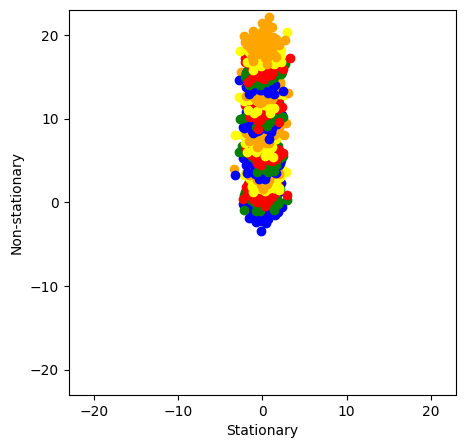

In [4]:
n_epochs = 20
data_set_size = 100
groups = {x:slice(x*data_set_size,(x+1)*data_set_size) for x in range(n_epochs)}
cols = ('blue','green','red','yellow','orange')


s_data = np.random.normal(loc = 0, scale = 1, size = data_set_size*n_epochs)
n_data = np.hstack([np.random.normal(loc = x, scale = 1, size = data_set_size) for x in range(n_epochs)])

lim = np.ceil(max(abs(s_data).max(),abs(n_data).max()))
plt.subplots(figsize = (5,5))
for x,sl in groups.items():
    plt.scatter(s_data[sl],n_data[sl],color=cols[x%5])
    plt.ylabel('Non-stationary')
    plt.xlabel('Stationary')
    plt.xlim((-lim,lim))
    plt.ylim((-lim,lim))

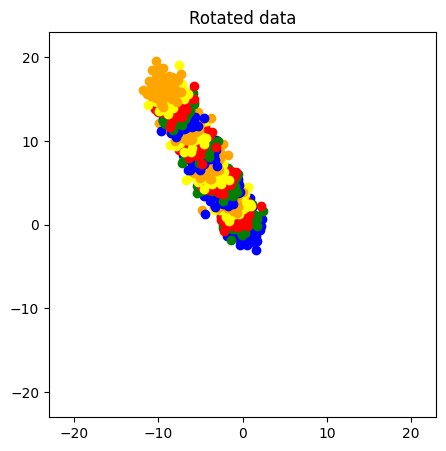

In [5]:
# Mixed data: 30-degree counterclockwise rotation of (stationary, non-stationary) data
m11,m12,m21,m22 = rotation_coefs(30)
d1 = m11*s_data + m12*n_data
d2 = m21*s_data + m22*n_data
# lim = np.ceil(max(abs(d1).max(),abs(d2).max()))
plt.subplots(figsize = (5,5))
for x,sl in groups.items():
    plt.scatter(d1[sl],d2[sl],color=cols[x%5])
    plt.xlim((-lim,lim))
    plt.ylim((-lim,lim))
    plt.title("Rotated data")
#     plt.axes().set_aspect('equal', 'datalim')

In [6]:
losses = []
angles = range(360)
for angle in angles:
    m11,m12,m21,m22 = rotation_coefs(angle)
    r_s = m11*d1 + m12*d2
    est_params = {x:(np.mean(r_s[sl]),np.var(r_s[sl])) for (x,sl) in groups.items()}
    losses.append(sum(kl_div_univariate(p,q) for (p,q) in combs(est_params.values(),2)))

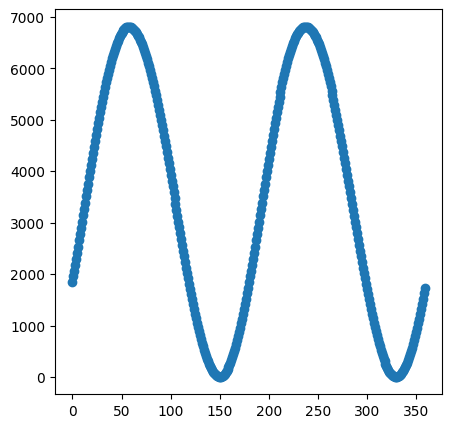

In [7]:
plt.subplots(figsize = (5,5))
plt.scatter(angles,losses)

In [8]:
opt = sopt.minimize(total_loss,x0=[0,0,0,0])
demixer = opt.x.reshape(2,2)

In [9]:
expm(demixer).dot(np.array(rotation_coefs(30)).reshape((2,2)))
# Perfect demixing => Identity matrix

array([[ 0.99994016,  0.00310303],
       [-0.00329262,  1.00004962]])